# TP Préparation données et estimation des données manquantes

**EL 3019 TP du 16/03/2022 - B.Roudier**


**SOMMAIRE**

    1. Introduction
    2. description des données
    3. Importation  
      3.1 Importation   
      3.2 Transformation de la variable CLASSE en variable catégorielle 
    4. Valeurs aberrantes
    5. Données manquantes 
        5.1 Visualisation 
        5.2 Imputation - unique   
        5.3 Cold-Deck KNN  


**1. Introduction**

Le prétraitement des données est un ensemble de techniques qui consiste à transformer
des données brutes dans un format lisible et compréhensible pour les méthodes
d’apprentissage statistiques. Les données réelles sont souvent incomplètes, incohérentes et
/ ou manquantes et/ ou contenir de nombreuses erreurs. Le prétraitement des données est
une phase indispensable avant l’utilisation de méthodes et algorithmes de machinelearning et d’IA. En fonction de la nature et de la qualité des données, elle comprend
différentes étapes s’articulant autour des problématiques suivantes :

• La détection des valeurs aberrantes
Comme nous l’avons vu dans le cours précédent, l’inclusion de valeurs aberrantes dans un
processus d’apprentissage peut avoir de graves répercussions dans l’interprétation des
résultats.

• L’estimation des données manquantes
La plupart des méthodes et algorithmes d’apprentissage nécessitent des jeux de données
complets. Il est donc indispensable d’estimer ces valeurs tout en préservant la distribution
de la variable considérée. Il s’agit de méthodes dites ‘d’imputations’. De nombreuses
méthodes existent dont certaines sont plus performantes que d’autres. Nous utiliserons
dans ce TP des méthodes par remplacement ainsi que des méthodes d’imputations simples
(Cold-Deck) par KNN (cf. cours).

• La standardisation des données
Il s’agit de rendre «indépendantes» les données de leur grandeur (métrique). En effet, de
nombreuses méthodes d’apprentissage nécessitent implicitement ou explicitement le calcul
de distances entre des individus ou entre les variables. Si, par exemple, une variable d’un
jeu de données est exprimée en mètre (taille d’un individu) et que vous la transformiez en 
cm (donc x 100), les résultats obtenus risques d’être complétement différents (‘effet loupe’).
La standardisation permet de rendre les données indépendantes de leur métrique. Cette
partie ne sera pas développée dans ce TP. Elle fera l’objet d’un cours et d’un TP ultérieur.

• Réaliser les statistiques univariées et bivariées
Cette partie est indispensable. Elle permet de “comprendre” les données, de “voir” les liens
existants entre les différentes variables / individus et leur nature (lineaires, non linéaires).

Elle inclut (au minimum):

• Une estimation des moyennes et quartiles

• Les distributions (histogrammes et densités de probabilité) de chaque variable

• Les correlations entre les variables et les scatter-plots qui permettent de voir la nature
des relations existantes (linéaires / non liénaires)

**2. DESCRIPTION DES DONNEES**


Le jeu de données comprend 700 patientes sur lesquelles il a été réalisée une biopsie du
sein pour étudier l’aspect des cellules (sous microscope - cytopathologie). L’objectif est de réaliser, en fonction de différents critères morphologiques (variables du jeu de données), un diagnostic de cancer. Ces critères sont quantifiés par une échelle allant de 1 à 10. La variable CLASSE est le diagnostic réalisé par l’expert qui évalue le caractère de malignité des cellules observées dans la biopsie (Gold Standard - Annotation). Les variables sont les suivantes

- E_MASSE : epaisseur (1 = normal+++ , 10 = normale---)
- UNI_TAILLE : uniformité de taille des cellules (1 = normal+++ , 10 =
normale---)
- UNI_FORME : uniformité de la forme des cellules (1 = normal+++ , 10 =
normale---)
- ADHESION : adhésion des cellules entre elles et à la couche basales (1 =
normal+++ , 10 = normale---)
- TAILLE_EPI : taille de la couche épithèliale sous jacente (1 = normal+++ ,
10 = normale---)
- NOYAUX : aspect du noyaux (1 = normal+++ , 10 = normale---)
- CHROMATINE : granule dans le noyau (1 = normal+++ , 10 = normale---)
- NOR_NUCLUS : aspect du nucleus (élement constitutif du noyau) (1 =
normal+++ , 10 = normale---)
- MITOSE : division cellulaire (1 = normal+++ , 10 = normale---)
- CLASSE : gold standard = annotation : 2 = Benin - 4 = Malin*

**3. IMPORTATION DES DONNEES**

3.1 Importation

3.1.1. Chargement des packages

In [1]:
import os
import numpy as np
import numpy.random as nr
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
import missingno as missviz

remarques importantes concernant les packages

• le package os est utilisé pouer la gestion des répertoires

• le package sklearn est utilisé pour l’imputation des données. Il s’agit d’un package très
important et très utilisé en python (scikit-learn) qui inclut un très grand nombre de
méthodes d’apprentissage

• le package missingno est utilisé pour visualiser le positionnement des données
manquantes dans un dataframe pour effectuer un diagnostic MAR/MCAR

**3.1.2. Chargement du fichier**

In [2]:
file = "Breast_MissData.xlsx"
df   = pd.read_excel(file,header = 0, na_values ='')
# La première variable correspond à des identifiants: On la supprime par délétion
df   = df.iloc[:,1:]
# Affichage des 4 premers enregistrements
print(df,3)


     E_MASSE  UNI_TAILLE  UNI_FORME  ADHESION  TAILLE_EPITH  NOYAUX  \
0        5.0         1.0        NaN       1.0           2.0     NaN   
1        NaN         4.0        4.0       5.0           NaN    10.0   
2        3.0         1.0        1.0       1.0           2.0     NaN   
3        6.0         8.0        NaN       NaN           NaN     4.0   
4        4.0         1.0        1.0       3.0           2.0     1.0   
..       ...         ...        ...       ...           ...     ...   
694      3.0         1.0        NaN       1.0           3.0     2.0   
695      2.0         1.0        NaN       NaN           2.0     NaN   
696      NaN        10.0        NaN       3.0           NaN     NaN   
697      4.0         8.0        6.0       4.0           3.0     4.0   
698      4.0         8.0        8.0       5.0           4.0     5.0   

     CHROMATINE  NORM_NUCLUS  MITOSES  CLASSE  
0           3.0          1.0      1.0       2  
1           3.0          2.0      1.0       2  
2  

**3.2. Transformation de la variable numérique CLASSE en variable catégorielle**
    
La variable CLASSE est une variable numérique. il convient donc dans un premier temps de
modifier les labels (2 et 4) (transformation en variable texte) puis de transfromer cette
variable en variable catégorielle. En effet, il est plus facile d’identifier le diagnostic
(annotation) des sujets par les labels ’Benin vs Malin" que par 2 et 4

In [3]:
#-> 1. Tranformation en caracteres 4 devient 'Malin' et 2 devient 'Benin'
new_lab = {'CLASSE': {4 : 'Malin' , 2 : 'Benin'} }

#-> 2. Labellisation da la cariable dans le data.frame
df.replace(new_lab, inplace = True)

#-> 3. Transformation character en catégorie de la variable
df['CLASSE'] = df['CLASSE'].astype('category')

#-> 4. On vérifie bien que la variable a été transformée
print(df['CLASSE'].unique())


['Benin', 'Malin']
Categories (2, object): ['Benin', 'Malin']


***

**4.Valeurs abérrantes**

- Dans un premier temps, on identifie les variables susceptibles de contenir des valeurs abbérantes. Pour y parvenir, on utilise la fonction *describe* qui fournit les statistiques descriptives. A partir de ces dernières, Comment procéderiez vous pour identifier la variable possédant des valeurs (très) abbérantes.

- Confirmer votre choix avec un box plot


          E_MASSE  UNI_TAILLE   UNI_FORME    ADHESION  TAILLE_EPITH  \
count  552.000000  537.000000  530.000000  549.000000    581.000000   
mean     4.447464    3.223464    3.271698    2.865209      3.172117   
std      2.824085    3.129418    2.990494    2.853486      2.194346   
min      1.000000    1.000000    1.000000    1.000000      1.000000   
25%      2.000000    1.000000    1.000000    1.000000      2.000000   
50%      4.000000    1.000000    2.000000    1.000000      2.000000   
75%      6.000000    5.000000    5.000000    4.000000      4.000000   
max     10.000000   10.000000   10.000000   10.000000     10.000000   

            NOYAUX  CHROMATINE  NORM_NUCLUS     MITOSES  
count   563.000000  560.000000   551.000000  570.000000  
mean     24.733570    3.519643     2.794918    1.615789  
std     183.090958    2.504302     3.024694    1.769125  
min       1.000000    1.000000     1.000000    1.000000  
25%       1.000000    2.000000     1.000000    1.000000  
50%       1.

<AxesSubplot:>

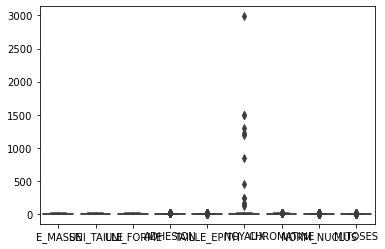

In [4]:
#-> 1.  Statistiques descriptives
dec   = df.describe()
print(dec)

#-> 2. Tracez un simple box plot pour identifier les (la) variable(s) avec
sns.boxplot(data = df)


   - Comme vous l'avez démontré, la variable *NOYAUX* possède des valeurs abbérantes. On considére que si cette variable est supérieure à 20 alors il s'agit d'une données abbérante. 
    - Ordonner les valeurs par ordre décroissant,
    - Compter le nombre de valeurs > 20
    - remplacer dans le data.frame les valeurs de la variable NOYAUX qui sont supérieures à 20 par des Na

In [5]:
# Sort .. juste pour voir le nombre de données > 20
test_val = df['NOYAUX'].sort_values(ascending = False)
test_val.head(17)

321    2987.0
145    1500.0
23     1500.0
139    1300.0
411    1230.0
40     1200.0
249     845.0
617     459.0
164     242.0
315     239.0
292     163.0
297     146.0
235     126.0
263      10.0
251      10.0
252      10.0
253      10.0
Name: NOYAUX, dtype: float64

In [6]:
# nombre de données > 20
# idx permet d identifier les lignes ou les valeurs de la varoable NOYAUX sont > 20 DANS le Dataframe ; retourne des booleans
idx   = df['NOYAUX'] > 20 ; print(idx)

nb_ab = idx.sum()         
print('\n') 
print('nombre de valeur > à 20 = ' + str(nb_ab))


0      False
1      False
2      False
3      False
4      False
       ...  
694    False
695    False
696    False
697    False
698    False
Name: NOYAUX, Length: 699, dtype: bool


nombre de valeur > à 20 = 13


In [7]:
# remplacer dans le dataframe les données abbérantes par des Na (en utilisant les index des lignes)
df.loc[idx,'NOYAUX'] = np.nan

# on pourrait aussi écrire directement
df.loc[df['NOYAUX'] > 20, 'NOYAUX'] = np.nan

# statitiques descriptives
rec_drop = df.describe()
print(rec_drop)


          E_MASSE  UNI_TAILLE   UNI_FORME    ADHESION  TAILLE_EPITH  \
count  552.000000  537.000000  530.000000  549.000000    581.000000   
mean     4.447464    3.223464    3.271698    2.865209      3.172117   
std      2.824085    3.129418    2.990494    2.853486      2.194346   
min      1.000000    1.000000    1.000000    1.000000      1.000000   
25%      2.000000    1.000000    1.000000    1.000000      2.000000   
50%      4.000000    1.000000    2.000000    1.000000      2.000000   
75%      6.000000    5.000000    5.000000    4.000000      4.000000   
max     10.000000   10.000000   10.000000   10.000000     10.000000   

           NOYAUX  CHROMATINE  NORM_NUCLUS     MITOSES  
count  550.000000  560.000000   551.000000  570.000000  
mean     3.614545    3.519643     2.794918    1.615789  
std      3.706019    2.504302     3.024694    1.769125  
min      1.000000    1.000000     1.000000    1.000000  
25%      1.000000    2.000000     1.000000    1.000000  
50%      1.000000 

**5. Données manquantes**  
5.1. Comptage
- Comptez le nombre et le pourcentage de valeurs manquantes par variable
- Comptez le pourcentage et nombre total de valeurs manquantes
- Créer une dataframe que vous appelerez *df_drop* dans laquelle toutes les lignes contenant des valeurs manquantes on été éliminées
- Comparez le nombre d'enregistrement entre *df* et *df_drop*. Que remarque t'on ?

    

In [8]:
# Nombre de valeurs manquantes et % par variables
[nrow, ncol] = df.shape
print('nombre de valeurs manquantes par variable dans le data.frame')
n_drop  = df.isna().sum() ; print(n_drop)
print('\n')
print('pourcentage de valeurs manquantes par variables')
pc_drop = n_drop / nrow * 100 ; print(pc_drop)
print('\n')

# Nombre de valeurs manquantes et % total
print('nombre total de valeurs manquantes dans le data.frame = ' + str(n_drop.sum()))
print('\n')
print('pourcentage de valeurs manquantes dans le data.frame = ' + str(n_drop.sum() / (nrow * ncol) * 100  ))


nombre de valeurs manquantes par variable dans le data.frame
E_MASSE         147
UNI_TAILLE      162
UNI_FORME       169
ADHESION        150
TAILLE_EPITH    118
NOYAUX          149
CHROMATINE      139
NORM_NUCLUS     148
MITOSES         129
CLASSE            0
dtype: int64


pourcentage de valeurs manquantes par variables
E_MASSE         21.030043
UNI_TAILLE      23.175966
UNI_FORME       24.177396
ADHESION        21.459227
TAILLE_EPITH    16.881259
NOYAUX          21.316166
CHROMATINE      19.885551
NORM_NUCLUS     21.173104
MITOSES         18.454936
CLASSE           0.000000
dtype: float64


nombre total de valeurs manquantes dans le data.frame = 1311


pourcentage de valeurs manquantes dans le data.frame = 18.755364806866954


In [9]:
# Creation du dataframe df_drop
# On élimine toutes les lignes(enregistrements) dont un des éléments ont une valeur NA
df_drop = df.dropna()
[nrow_drop, ncol ] = df_drop.shape
print('nombre d enregistrement de df_drop = ' + str(nrow_drop))
print('nombre d enregistrement de df      = ' + str(nrow))



nombre d enregistrement de df_drop = 97
nombre d enregistrement de df      = 699


5.2. Visualisation des données manquantes
Nous utilisons 3 graphiques :
- Visualisation du positionnement des données manquantes dans la dataframe : missviz.matrix(pd.DataFrame(df))
- Visualisation du nombre de données non manquantes par variable :missviz.bar(pd.DataFrame(df))
- Visualisation de la 'relation' entre les variables pour les données manquantes 0 : pas de relation : 1 et -1 : forte relation  missviz.heatmap(pd.DataFrame(df))

• Question : D’après le graphique précèdent, quel est selon vous la typologie des données manquantes ?

<AxesSubplot:>

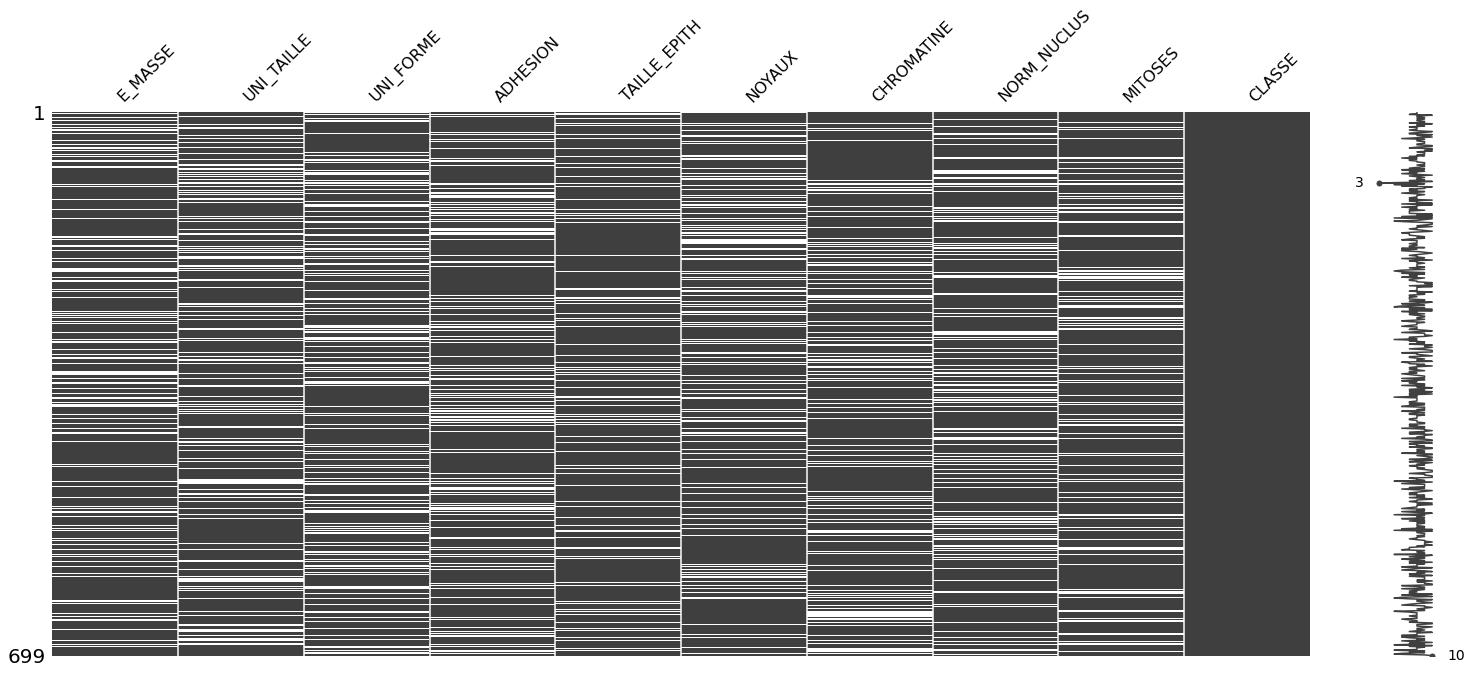

In [10]:
#-> vizualisation positionnement dans la matrice
missviz.matrix(pd.DataFrame(df))

<AxesSubplot:>

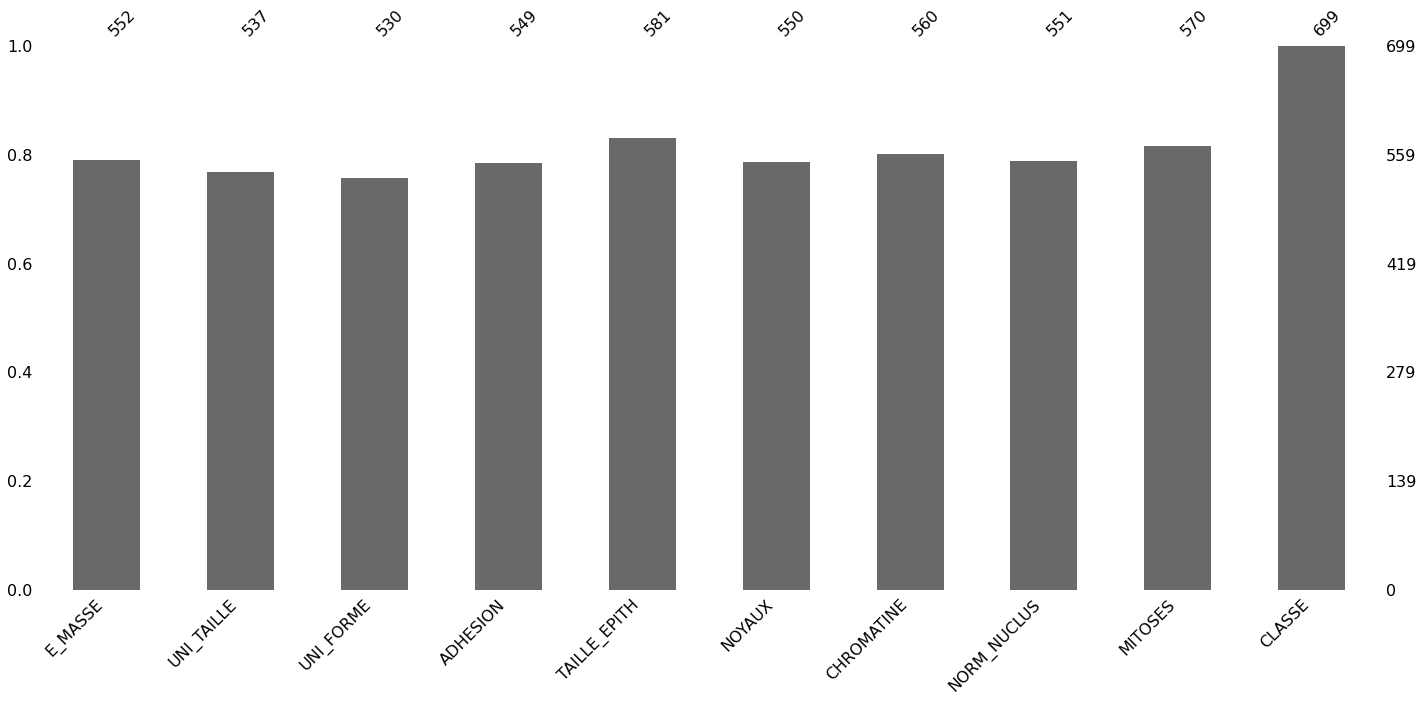

In [11]:
#-> nombre de valeurs non Nan par variable
missviz.bar(pd.DataFrame(df))

<AxesSubplot:>

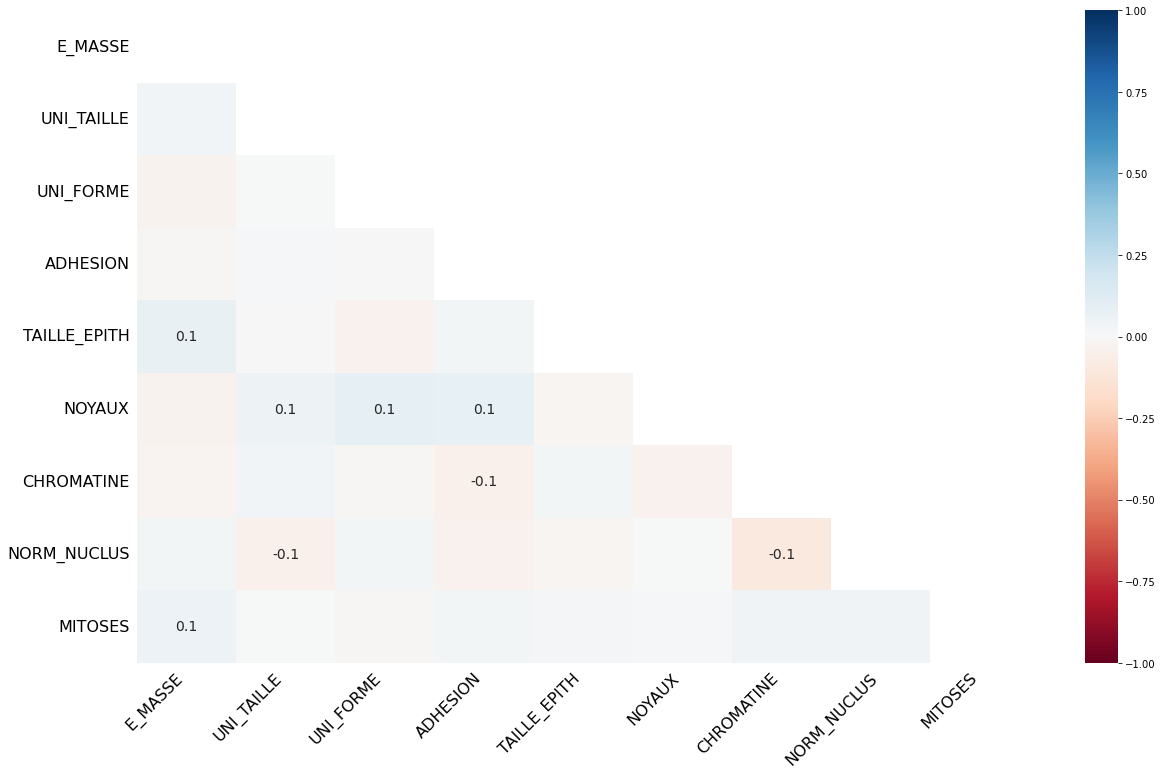

In [12]:
#-> dépendance
missviz.heatmap(pd.DataFrame(df))

***

**5.2. Imputation par une valeur unique dans le cas de variable numérique**

Il s’agit de remplacer toutes les valeurs *numériques* manquantes par une seule valeur qui peut être (i) la moyenne, (ii) la médiane, (iii)  la valeur la plus fréquente. 
Dans un premier temps on crée un dataframe *df_num* dans lequel toutes les variable sont numériques (type float64). ce qui 
équivaut à éliminer la variable CLASSE 

Dans un second temps, on utilise La méthode SimpleImputer (qui est en fait une classe) et qui fonctionne en 3 phases
- on déclare le modèle (appel à un constructeur)
- … puis on effectue l’estimation
- ….puis on impute les données manquantes dans le dataFrame

• Le code suivant effectue les imputations respectivement avec la moyenne, la médiane,
et la valeur la plus fréquente

• Pour chaque méthode d’estimation, on calcule les statistiques descriptives puis le
coefficient de varition (CV) qui correspond au rapport de la déviation standard à la
moyenne. ce ceofficient correspond à la dispertion autour de la tendence centrale. Que
remarque-t’on ?

In [13]:
# on crée df_num en sélectionnant uniquement les variables de type : float64
df_num = df.select_dtypes(include = ['float64'])
df_num.head()

,E_MASSE,UNI_TAILLE,UNI_FORME,ADHESION,TAILLE_EPITH,NOYAUX,CHROMATINE,NORM_NUCLUS,MITOSES
0,5.0,1.0,NaN,1.0,2.0,NaN,3.0,1.0,1.0
1,NaN,4.0,4.0,5.0,NaN,10.0,3.0,2.0,1.0
2,3.0,1.0,1.0,1.0,2.0,NaN,3.0,1.0,NaN
3,6.0,8.0,NaN,NaN,NaN,4.0,3.0,7.0,1.0
4,4.0,1.0,1.0,3.0,2.0,1.0,3.0,1.0,1.0


In [14]:
#-> Déclaration du modèle : paramètre la moyenne
fun = SimpleImputer(missing_values = np.nan , strategy = 'mean')
#-> On effectue l'estimation
fun.fit(df_num) 
#-> on récupère le dataframe avec les valeurs imputées
df_mean      = pd.DataFrame(fun.transform(df_num))
df_mean_stat = df_mean.describe()

print( '\n' + 'Statistiques déscriptives: Moyenne')
print(df_mean_stat)
#-> Calcul des % de variation
#-> df_mean_stat est un objet Panda: on récupère les lignes 1 et 2
mean_CV = df_mean_stat.iloc[2,:] / df_mean_stat.iloc[1,:] *100 

print( '\n' + 'Coefficients de variation en %') 
mean_CV.index = df_num.columns.tolist()
print(mean_CV)


Statistiques déscriptives: Moyenne
                0           1           2           3           4           5  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean     4.447464    3.223464    3.271698    2.865209    3.172117    3.614545   
std      2.509146    2.742320    2.603413    2.528357    2.000282    3.286746   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      4.447464    3.000000    3.271698    2.000000    2.000000    3.000000   
75%      5.000000    3.223464    4.000000    3.000000    3.172117    4.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

                6           7           8  
count  699.000000  699.000000  699.000000  
mean     3.519643    2.794918    1.615789  
std      2.241119    2.684943    1.597302  
min      1.000000    1.000000    1.000000  
25%      2.000

In [15]:
#-> Déclaration du modèle : paramètre la médiane
fun = SimpleImputer(missing_values = np.nan , strategy = 'median')
#-> On effectue l'estimation
fun.fit(df_num) 

#-> on récupère le dataframe avec les valeurs imputées
df_median      = pd.DataFrame(fun.transform(df_num))
df_median_stat = df_median.describe()
print( '\n' + 'Statistiques déscriptives : Mediane')
print(df_median_stat)

#-> Calcul des % de variation
#-> df_mean_stat est un objet Panda: on récupère les lignes 1 et 2
median_CV = df_median_stat.iloc[2,:] / df_median_stat.iloc[1,:] *100 

print( '\n' + 'Coefficients de variation en %') 
median_CV.index = df_num.columns.tolist()
print(median_CV)



Statistiques déscriptives : Mediane
                0           1           2           3           4           5  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean     4.353362    2.708155    2.964235    2.464950    2.974249    3.057225   
std      2.515772    2.898588    2.659821    2.641929    2.047969    3.457004   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      3.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      4.000000    1.000000    2.000000    1.000000    2.000000    1.000000   
75%      5.000000    3.000000    4.000000    3.000000    3.000000    4.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

                6           7           8  
count  699.000000  699.000000  699.000000  
mean     3.416309    2.414878    1.502146  
std      2.250710    2.783415    1.615091  
min      1.000000    1.000000    1.000000  
25%      2.00

In [16]:
#-> Déclaration du modèle : paramètre la veleur la plus fréquente
fun = SimpleImputer(missing_values = np.nan , strategy = 'most_frequent')
#-> On effectue l'estimation
fun.fit(df_num) 
#-> on récupère le dataframe avec les valeurs imputées
df_freq      = pd.DataFrame(fun.transform(df_num))
df_freq_stat = df_freq.describe()

print( '\n' + 'Statistiques déscriptives : valeur la plus fréquente')
print(df_freq_stat)

#-> Calcul des % de variation
#-> df_mean_stat est un objet Panda: on récupère les lignes 1 et 2
freq_CV = df_freq_stat.iloc[2,:] / df_freq_stat.iloc[1,:] *100 

print( '\n' + 'Coefficients de variation en %') 
freq_CV.index = df_num.columns.tolist()
print(freq_CV)



Statistiques déscriptives : valeur la plus fréquente
                0           1           2           3           4           5  \
count  699.000000  699.000000  699.000000  699.000000  699.000000  699.000000   
mean     3.722461    2.708155    2.722461    2.464950    2.974249    3.057225   
std      2.876184    2.898588    2.779416    2.641929    2.047969    3.457004   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      1.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
50%      3.000000    1.000000    1.000000    1.000000    2.000000    1.000000   
75%      5.000000    3.000000    4.000000    3.000000    3.000000    4.000000   
max     10.000000   10.000000   10.000000   10.000000   10.000000   10.000000   

                6           7           8  
count  699.000000  699.000000  699.000000  
mean     3.217454    2.414878    1.502146  
std      2.321862    2.783415    1.615091  
min      1.000000    1.000000    1.00000

• Question : Comparer les CV% entre les 3 méthodes

• Comme on peut le constater, les mêmes programmes sont réalisés 3 fois entrainant un
nombre de lignes de code important. Il serait peut être judicieux d’écrire une petite
fonction qui encapsule le code par exemple :
    

In [17]:
def Imputation_Simple(num_ar,miss_val = np.nan, method = 'mean'):
    try:
        fun = SimpleImputer(missing_values = np.nan , strategy = method)
        fun.fit(num_ar) # set
        num_ar_imputed = fun.transform(num_ar)

    except ValueError:
        print("l'argument data n'est pas conforme")
        return(999)
    else:
        return(num_ar_imputed)

In [18]:
# Appel de la fonction
# Imputation par la moyenne -->
df_impMean = Imputation_Simple(num_ar = df_num)
# Imputation par la médiane -->
df_impMedian = Imputation_Simple(num_ar = df_num, method = 'median')
# imputation par la valeur la plus féquente -->
df_impMostFreq = Imputation_Simple(num_ar = df_num, method = 'most_frequent')
# et voilà

**5.3. Cold-Deck : KNN**

La méthode d’imputation par les K-plus proches voisins est réalisée par une classe qui
fonctionne de manière analogue à celle vue pour l’imputation par une valeur unique. La
méthode KNNImputer fonctionne aussi en trois étapes + on déclare le modèle; il s’agit de la
fonction KNNImputer dans laquelle on assigne le nombre de K plus proches voisins (appel à
un constructeur) + … puis on effectue l’estimation + ….puis on impute les données
manquantes dans la dataFrame.
Le scriptsuivant réalise une imputation avec les 5 plus proches voisins


In [19]:
fun = KNNImputer(missing_values = np.nan ,n_neighbors = 5)
fun.fit(df_num) 
df_KNN_5   = pd.DataFrame(fun.transform(df_num))
stat_KNN_5 = df_KNN_5.describe()
stat_KNN_5.loc['std',:] / stat_KNN_5 .loc['mean',:] *100


0     61.578089
1     96.229251
2     91.608063
3     97.988715
4     67.093923
5    101.462502
6     69.550040
7    104.619349
8    104.018939
dtype: float64

Réalisez une fonction qui permet de calculer les imputations de manière automatique.  Cette fonction retourne un dictionnaire avec les éléments suivants :
 - Le data frame des valeurs imputées
 - les statistiques descriptives
 - les coefficients de variations


In [20]:
# Fonction
def KNN(df, n_ppv):
    fun = KNNImputer(missing_values = np.nan ,n_neighbors = n_ppv)
    fun.fit(df)
    df_out  = pd.DataFrame(fun.transform(df))
    df_out.columns = df.columns.tolist()
    
    df_stat = df_out.describe()
    
    df_CV   = df_stat.iloc[2,:] / df_stat.iloc[1,:] *100 
    df_CV.index = df.columns.tolist()

    return { 'data' : df_out, 'stat' : df_stat, 'cv' : df_CV  }

result = KNN(df_num,  10)

print(result['data'])
print('\n')
print(result['stat'])
print('\n')
print(result['cv'])


     E_MASSE  UNI_TAILLE  UNI_FORME  ADHESION  TAILLE_EPITH  NOYAUX  \
0        5.0         1.0        1.0       1.0           2.0     1.0   
1        8.0         4.0        4.0       5.0           3.9    10.0   
2        3.0         1.0        1.0       1.0           2.0     1.4   
3        6.0         8.0        4.9       2.8           4.5     4.0   
4        4.0         1.0        1.0       3.0           2.0     1.0   
..       ...         ...        ...       ...           ...     ...   
694      3.0         1.0        1.3       1.0           3.0     2.0   
695      2.0         1.0        1.0       1.1           2.0     1.0   
696      7.8        10.0        8.5       3.0           6.3     5.1   
697      4.0         8.0        6.0       4.0           3.0     4.0   
698      4.0         8.0        8.0       5.0           4.0     5.0   

     CHROMATINE  NORM_NUCLUS  MITOSES  
0           3.0          1.0      1.0  
1           3.0          2.0      1.0  
2           3.0          1.

Cette méthode d'imputation pose le problème du choix des k plus proches voisins.
Utilisez la fonction pour calculer les valeur imputées avec K = 1, 5, 10, 15, 20, 30, 50 
A partir des CV, quelle serait, selon vous le k optimal ?

In [21]:
knn = [1,5,10,15,20,30,50]

c = pd.DataFrame()
for i in knn:
    res = KNN(df_num,  i)
    c   = pd.concat([c, res['cv']], axis = 1)
print(c)
 

                       0           0           0           0           0  \
E_MASSE        62.752079   61.578089   60.985779   60.900523   60.697029   
UNI_TAILLE     98.871859   96.229251   96.680852   96.540326   96.540843   
UNI_FORME      93.305427   91.608063   91.633754   91.484781   91.238062   
ADHESION      101.922697   97.988715   97.578261   97.224058   97.193611   
TAILLE_EPITH   69.178046   67.093923   66.693777   66.525871   66.550504   
NOYAUX        103.748898  101.462502  101.356318  100.936653  100.787067   
CHROMATINE     68.413309   69.550040   69.337194   69.039278   68.972244   
NORM_NUCLUS   108.606755  104.619349  103.653587  103.447563  103.085009   
MITOSES       107.984052  104.018939  103.257847  102.743928  102.818306   

                       0           0  
E_MASSE        60.598326   60.498177  
UNI_TAILLE     96.552514   96.448982  
UNI_FORME      91.037793   90.754064  
ADHESION       97.179328   97.004455  
TAILLE_EPITH   66.279606   66.226926  
NOYAU